In [1]:
%pylab inline
import cv2 as cv
import numpy as np
import argparse

Populating the interactive namespace from numpy and matplotlib


In [2]:

#     # window size is WxW
# C_Thr = 0.43    # threshold for coherency
# LowThr = 35     # threshold1 for orientation, it ranges from 0 to 180
# HighThr = 57    # threshold2 for orientation, it ranges from 0 to 180

def calcGST(inputIMG, w):
    img = inputIMG.astype(np.float32)
    # GST components calculation (start)
    # J =  (J11 J12; J12 J22) - GST
    imgDiffX = cv.Sobel(img, cv.CV_32F, 1, 0, 3)
    imgDiffY = cv.Sobel(img, cv.CV_32F, 0, 1, 3)
    imgDiffXY = cv.multiply(imgDiffX, imgDiffY)
    
    imgDiffXX = cv.multiply(imgDiffX, imgDiffX)
    imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w,w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w,w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w,w))
    # GST components calculations (stop)
    # eigenvalue calculation (start)
    # lambda1 = J11 + J22 + sqrt((J11-J22)^2 + 4*J12^2)
    # lambda2 = J11 + J22 - sqrt((J11-J22)^2 + 4*J12^2)
    tmp1 = J11 + J22
    tmp2 = J11 - J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0 * tmp3)
    lambda1 = tmp1 + tmp4    # biggest eigenvalue
    lambda2 = tmp1 - tmp4    # smallest eigenvalue
    # eigenvalue calculation (stop)
    # Coherency calculation (start)
    # Coherency = (lambda1 - lambda2)/(lambda1 + lambda2)) - measure of anisotropism
    # Coherency is anisotropy degree (consistency of local orientation)
    imgCoherencyOut = cv.divide(lambda1 - lambda2, lambda1 + lambda2)
    # Coherency calculation (stop)
    # orientation angle calculation (start)
    # tan(2*Alpha) = 2*J12/(J22 - J11)
    # Alpha = 0.5 atan2(2*J12/(J22 - J11))
    imgOrientationOut = cv.phase(J22 - J11, 2.0 * J12, angleInDegrees = True)
    imgOrientationOut = 0.5 * imgOrientationOut
    # orientation angle calculation (stop)
    return imgCoherencyOut, imgOrientationOut, J11, J22, J12

imgIn_pre = cv.imread("/data/SciBigData/radargrams/nicole_thesis/s_00325703_thm.jpg", cv.IMREAD_GRAYSCALE)[2000:3000, 1000:3000]

# imgIn = cv.GaussianBlur(imgIn, (21,21), 10)

imgIn = cv.fastNlMeansDenoising(imgIn_pre,None,20,7,21)
cv.imwrite('test.jpg', imgIn)

W = 10
imgCoherency, ori, J11, J22, J12 = calcGST(imgIn, W)

ori[ori>=90] -=180

_, imgCoherencyBin = cv.threshold(imgCoherency,0.1, 255, cv.THRESH_BINARY)
# _, ori_bin = cv.threshold(ori,-20, 20, cv.THRESH_BINARY)
ori_bin = cv.inRange(ori, -50, 50)

imgBin = cv.bitwise_and(imgCoherencyBin, ori_bin.astype(np.float32))
# imgCoherency = cv.normalize(imgCoherency, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
# imgOrientation = cv.normalize(imgOrientation, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
# cv.imshow('result.jpg', np.uint8(0.5*(imgIn + imgBin)))
# cv.imshow('Coherency.jpg', imgCoherency)
# cv.imshow('Orientation.jpg', imgOrientation)
# cv.waitKey(0)

In [3]:
import rsf

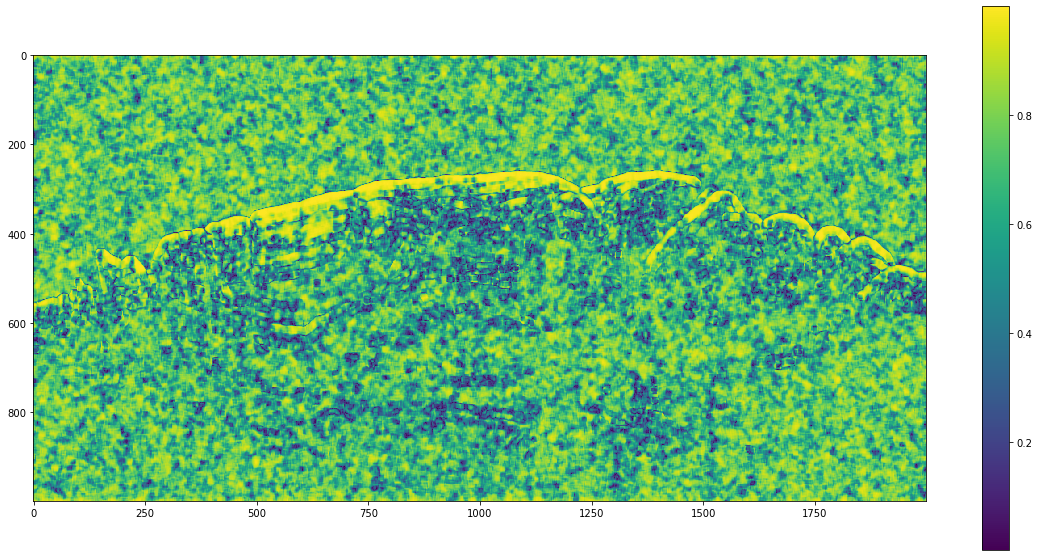

In [35]:
figure(figsize=(20,10))

imshow(imgCoherency)
colorbar()

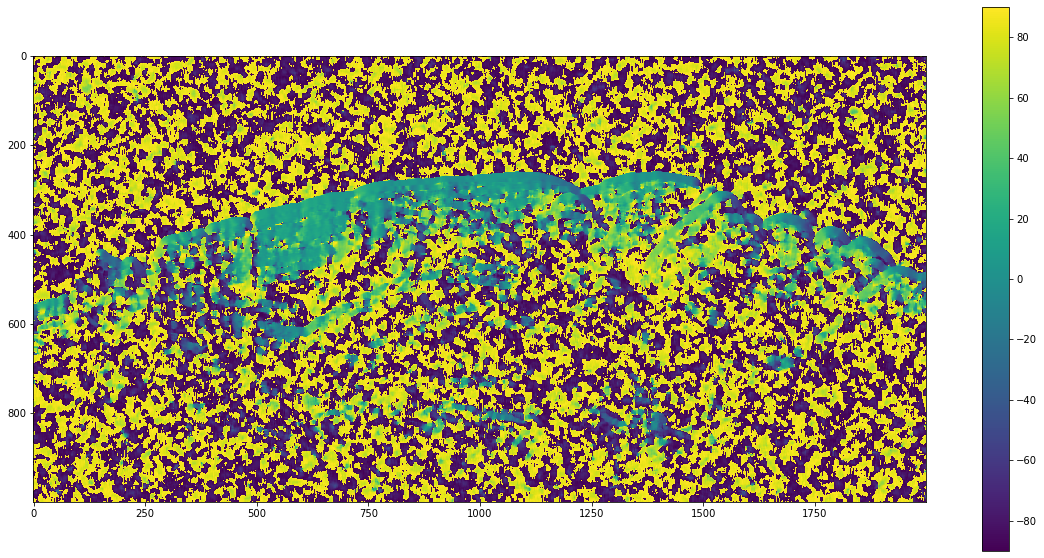

In [34]:
figure(figsize=(20,10))

imshow(ori)
colorbar()

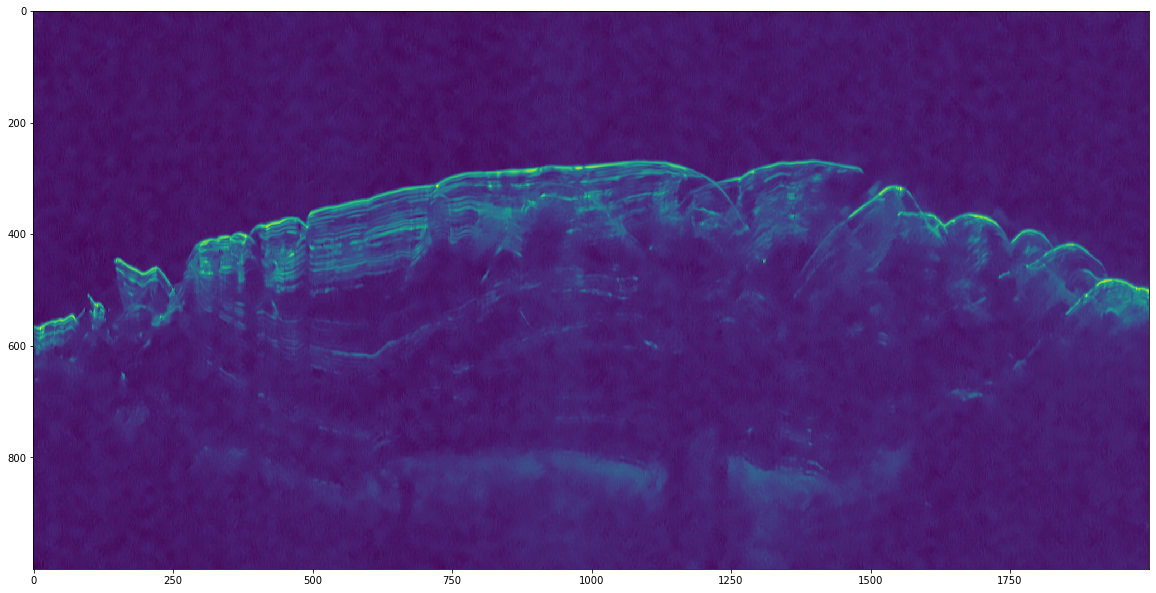

In [4]:
figure(figsize=(20,20))
imshow(imgIn)

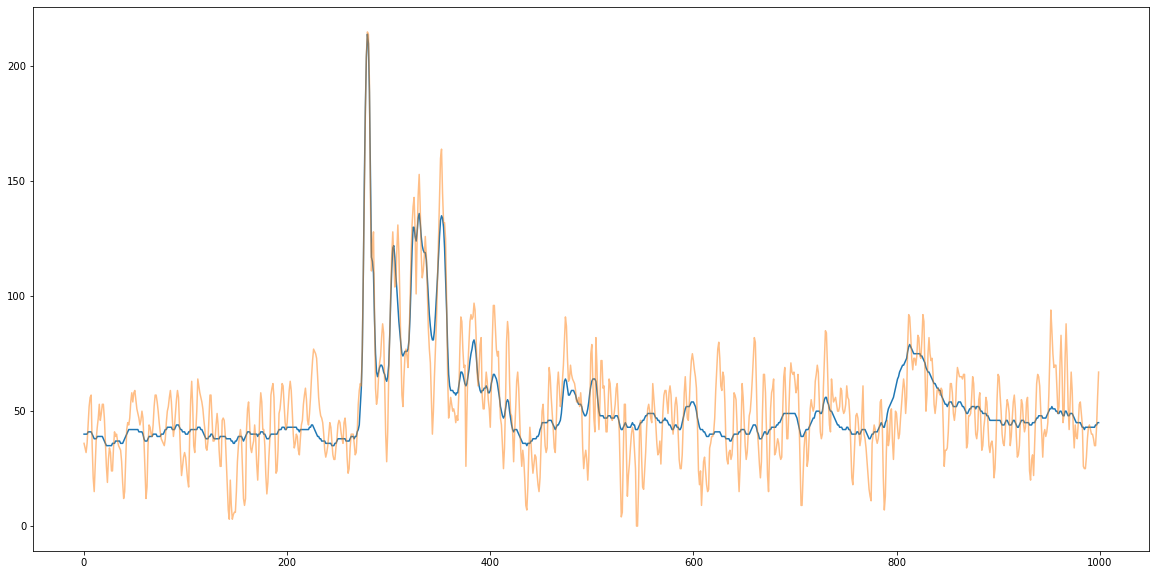

In [5]:
figure(figsize=(20,10))
a = imgIn[:,1000]
plot(a)
a = imgIn_pre[:,1000]
plot(a,alpha=0.5)

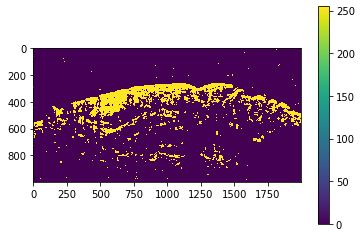

In [6]:
imshow(ori_bin)
colorbar()

In [7]:
dilation_size = 5
element = cv.getStructuringElement( cv.MORPH_ELLIPSE,
                                       ( 2*dilation_size + 1, 2*dilation_size+1 ),
                                       ( dilation_size, dilation_size ) );

In [8]:
eroded = cv.erode(imgBin, element)
imgBin = cv.dilate(eroded, element)

In [9]:
res = np.uint8(0.5*(imgIn + imgBin))
# cv.imwrite("result.jpg", res)
# cv.imwrite('Coherency.jpg', imgCoherency)
# cv.imwrite('Orientation.jpg', imgOrientation)

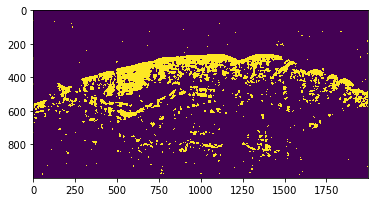

In [10]:



imshow(ori_bin)

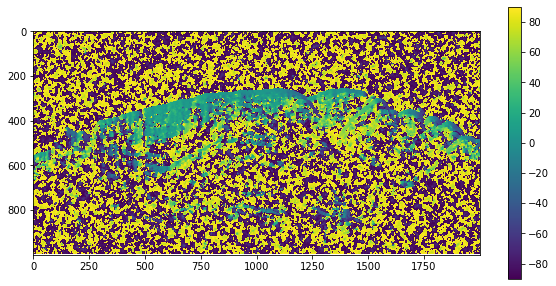

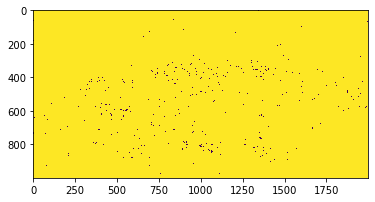

In [11]:

figure(figsize=(10,5))
imshow(ori)
colorbar()
figure()
imshow(imgCoherencyBin)

(array([1.475341e+06, 3.727900e+05, 9.050300e+04, 3.326900e+04,
        1.474400e+04, 6.785000e+03, 4.174000e+03, 1.889000e+03,
        4.540000e+02, 5.100000e+01]),
 array([ 25. ,  47.1,  69.2,  91.3, 113.4, 135.5, 157.6, 179.7, 201.8,
        223.9, 246. ]),
 <a list of 10 Patch objects>)

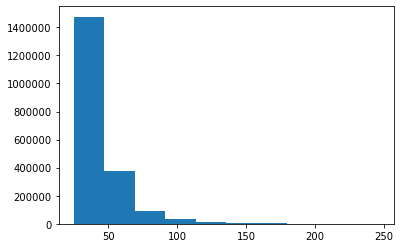

In [12]:
hist(imgIn.ravel())

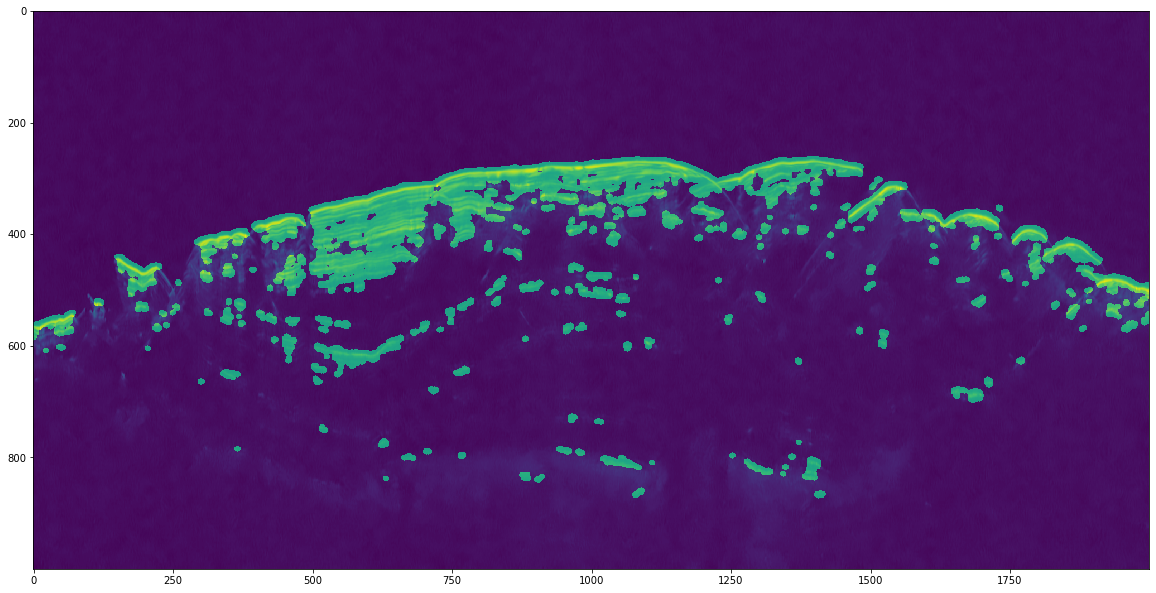

In [13]:
figure(figsize=(20,20))
imshow(res)

In [14]:
cv.ximgproc.anisotropicDiffusion?

Docstring:
anisotropicDiffusion(src, alpha, K, niters[, dst]) -> dst
.   @brief Performs anisotropic diffusian on an image.
.   
.    The function applies Perona-Malik anisotropic diffusion to an image. This is the solution to the partial differential equation:
.   
.    \f[{\frac  {\partial I}{\partial t}}={\mathrm  {div}}\left(c(x,y,t)\nabla I\right)=\nabla c\cdot \nabla I+c(x,y,t)\Delta I\f]
.   
.    Suggested functions for c(x,y,t) are:
.   
.    \f[c\left(\|\nabla I\|\right)=e^{{-\left(\|\nabla I\|/K\right)^{2}}}\f]
.   
.    or
.   
.    \f[ c\left(\|\nabla I\|\right)={\frac {1}{1+\left({\frac  {\|\nabla I\|}{K}}\right)^{2}}} \f]
.   
.    @param src Source image with 3 channels.
.    @param dst Destination image of the same size and the same number of channels as src .
.    @param alpha The amount of time to step forward by on each iteration (normally, it's between 0 and 1).
.    @param K sensitivity to the edges
.    @param niters The number of iterations
Type:      builtin_fu

In [15]:
edges = cv.Canny(imgIn,50,100)

In [16]:
# edges = cv.Canny

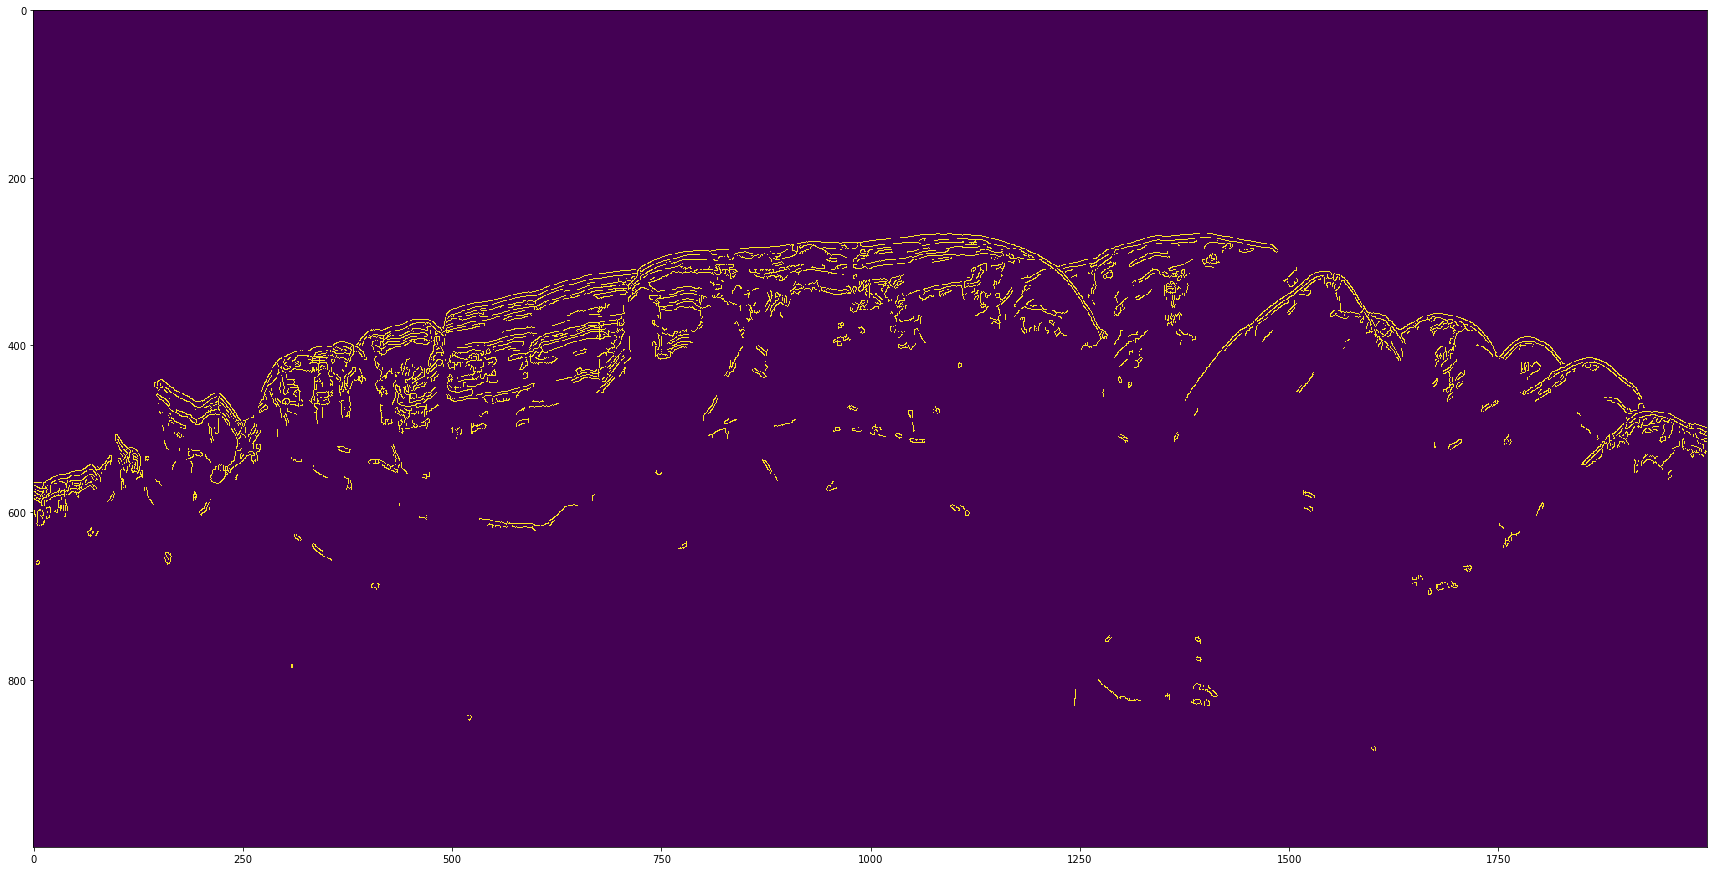

In [17]:
figure(figsize=(30,30))
imshow(edges)

In [18]:
ridge_filter.getRidgeFilteredImage?

Object `ridge_filter.getRidgeFilteredImage` not found.


In [19]:
ridge_filter = cv.ximgproc.RidgeDetectionFilter_create()
ridges = ridge_filter.getRidgeFilteredImage(imgIn)

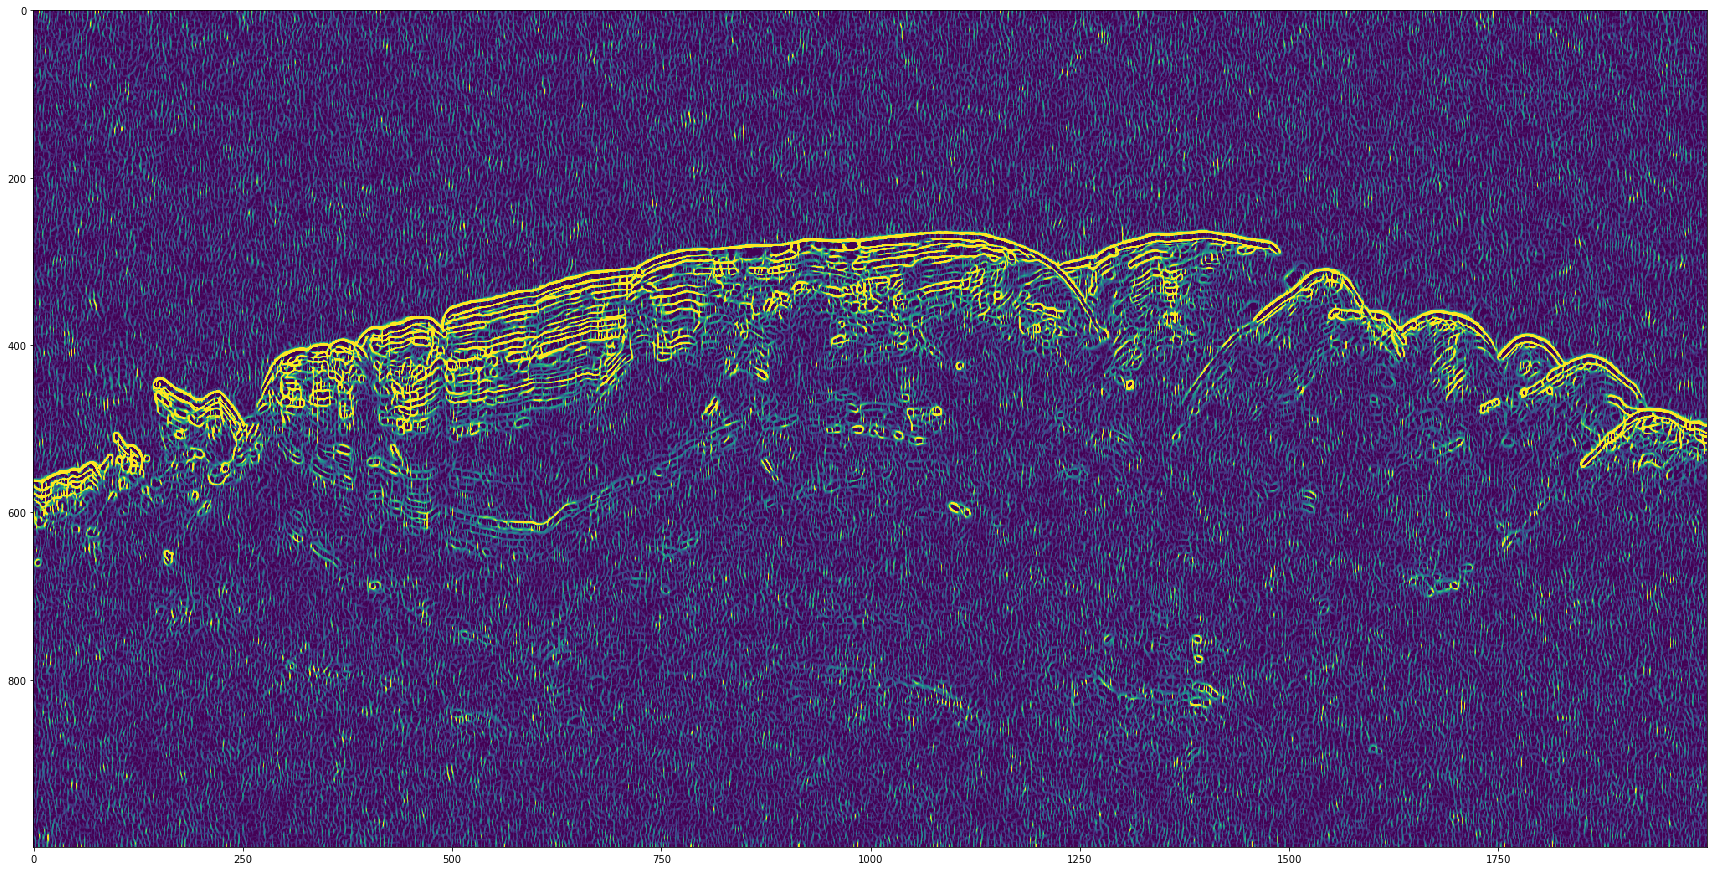

In [20]:
figure(figsize=(30,30))
imshow(ridges)

In [21]:
cv.imwrite('test.jpg', imgIn)
cv.imwrite('ridge.jpg', ridges)

True

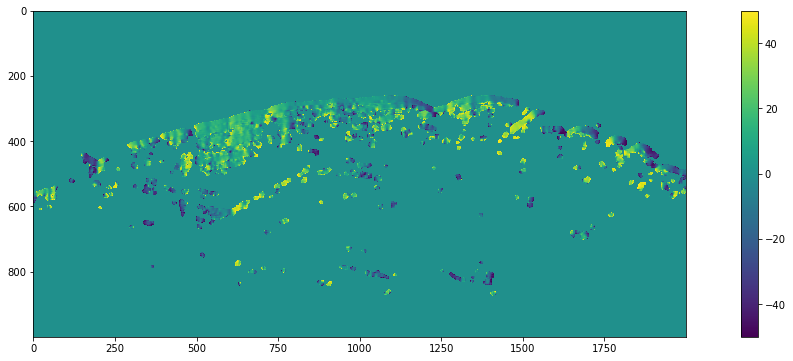

In [30]:
res = cv.bitwise_and(ori,ori,mask = imgBin.astype(np.uint8))
figure(figsize=(20,6))

imshow(res)
colorbar()

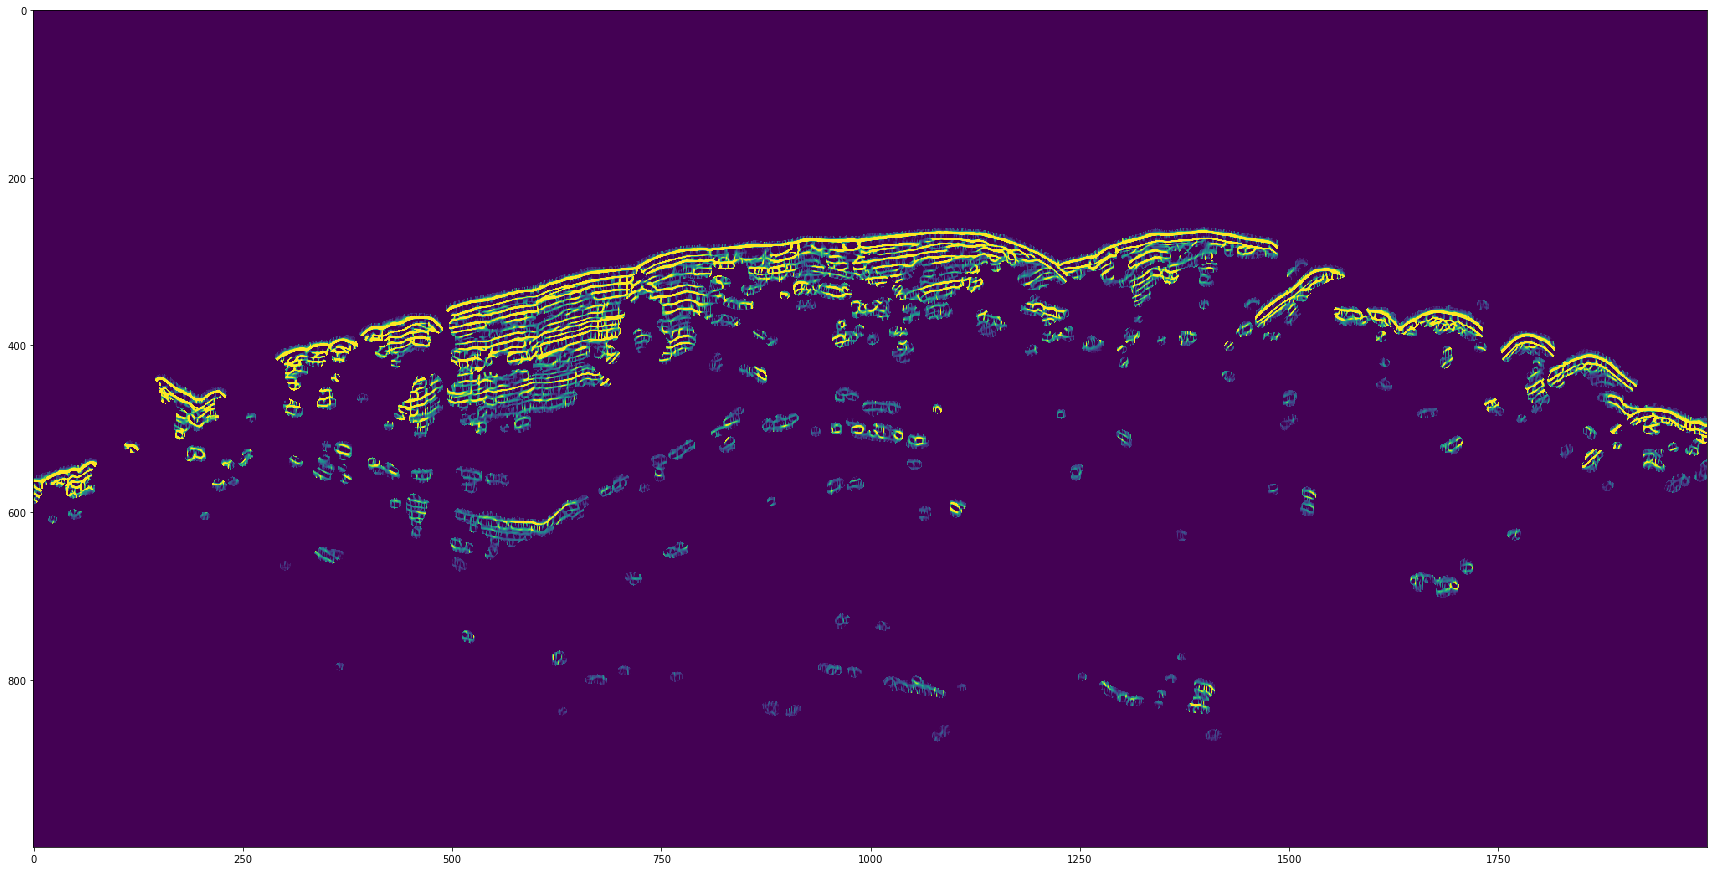

In [23]:


res = cv.bitwise_and(ridges,ridges,mask = imgBin.astype(np.uint8))
figure(figsize=(30,30))
imshow(res)

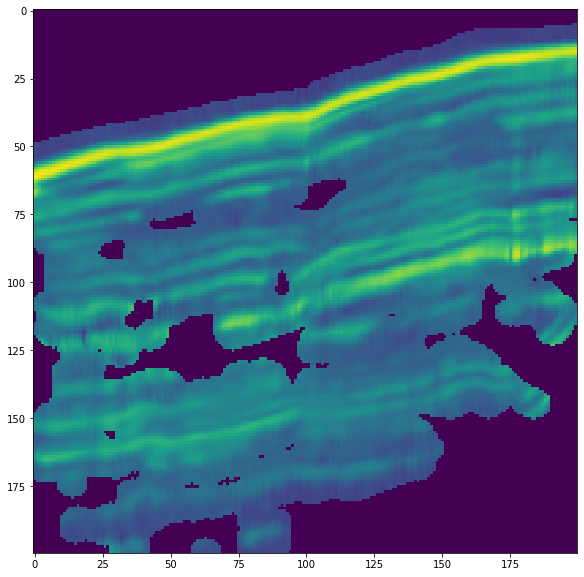

In [24]:
res = cv.bitwise_and(imgIn,imgIn,mask = imgBin.astype(np.uint8))
figure(figsize=(10,10))
imshow(res)


sub = res[300:500, 500:700]
imshow(sub)

In [25]:
# %pylab qt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
lena = sub
import PIL

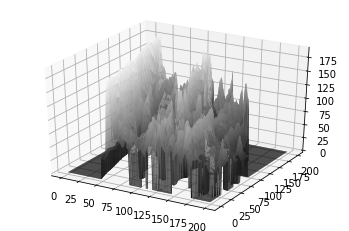

In [26]:

# from scipy.misc import imresize

# downscaling has a "smoothing" effect



# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:lena.shape[0], 0:lena.shape[1]]

# create the figure
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, lena ,rstride=1, cstride=1, cmap=plt.cm.gray,
        linewidth=0)

# show it
plt.show()